# Decision tree for 0MA+enumeration queries
## DuckDB, basic features+DDB features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [3]:
file_path = 'results/features_times_DDB_extra_full_enum_infos.csv'
df1 = pd.read_csv(file_path)

In [4]:
file_path = 'results/features_times_DDB_extra_infos.csv'
df2 = pd.read_csv(file_path)

In [5]:
cols = ['bench', 'query', 'orig/rewr(med)', 'orig(med)', 'rewr(med)',
       '#relations', '#conditions', '#filters', '#joins',
       'min(est. cardinality)', 'max(est. cardinality)',
       'mean(est. cardinality)', 'q25(est. cardinality)',
       'median(est. cardinality)', 'q75(est. cardinality)', 'depth',
       'min(container counts)', 'max(container counts)',
       'mean(container counts)', 'q25(container counts)',
       'median(container counts)', 'q75(container counts)',
       'min(branching factors)', 'max(branching factors)',
       'mean(branching factors)', 'median(branching factors)',
       'q25(branching factors)', 'q75(branching factors)']

In [6]:
df1 = df1[cols]
df2 = df2[cols]
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

bench                query orig/rewr(med)            orig(med)  \
0  STATS        001-014-full1           orig  0.15207529067993164   
1  STATS        001-014-full2           orig  0.15242338180541992   
2  STATS        001-014-full3           orig  0.15196943283081055   
3  STATS  001-014-augF1-full1           orig  0.15015530586242676   
4  STATS  001-014-augF1-full2           orig  0.15279197692871094   

             rewr(med)  #relations  #conditions  #filters  #joins  \
0  0.16910672187805176           3            7         5       2   
1  0.16997671127319336           3            7         5       2   
2  0.17494964599609375           3            7         5       2   
3  0.16517901420593262           3            7         5       2   
4  0.16912555694580078           3            7         5       2   

   min(est. cardinality)  ...  mean(container counts)  q25(container counts)  \
0                   6831  ...                1.133333                    1.0   
1                   6831  ...                1.133333                    1.0   
2                   6831  ...                1.133333                    1.0   
3                   6831  ...                1.133333                    1.0   
4                   6831  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       2                      2.0                        2.0   
2                       2                      2.0                        2.0   
3                       2                      2.0                        2.0   
4                       2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 28 columns]

In [7]:
df.shape

(3861, 28)

#### Delete those examples, where both methods gave a timeout

In [8]:
df[df["orig/rewr(med)"] == "-"].shape

(301, 28)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [9]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(3560, 28)

In [10]:
df[df["orig(med)"] == "TO"].shape

(167, 28)

In [12]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [13]:
df[df["rewr(med)"] == "TO"].shape

(72, 28)

In [14]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [15]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [16]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [17]:
X = df.iloc[:, 5:28]
X.head()

#relations  #conditions  #filters  #joins  min(est. cardinality)  \
0           3            7         5       2                   6831   
1           3            7         5       2                   6831   
2           3            7         5       2                   6831   
3           3            7         5       2                   6831   
4           3            7         5       2                   6831   

   max(est. cardinality)  mean(est. cardinality)  q25(est. cardinality)  \
0                  49680                24924.25                 6909.0   
1                  49680                24924.25                 6909.0   
2                  49680                24924.25                 6909.0   
3                  49680                24924.25                 6909.0   
4                  49680                24924.25                 6909.0   

   median(est. cardinality)  q75(est. cardinality)  ...  \
0                   22381.0               38426.25  ...   
1                   22381.0               38426.25  ...   
2                   22381.0               38426.25  ...   
3                   22381.0               38426.25  ...   
4                   22381.0               38426.25  ...   

   mean(container counts)  q25(container counts)  median(container counts)  \
0                1.133333                    1.0                       1.0   
1                1.133333                    1.0                       1.0   
2                1.133333                    1.0                       1.0   
3                1.133333                    1.0                       1.0   
4                1.133333                    1.0                       1.0   

   q75(container counts)  min(branching factors)  max(branching factors)  \
0                    1.0                       2                       2   
1                    1.0                       2                       2   
2                    1.0                       2                       2   
3                    1.0                       2                       2   
4                    1.0                       2                       2   

   mean(branching factors)  median(branching factors)  q25(branching factors)  \
0                      2.0                        2.0                     2.0   
1                      2.0                        2.0                     2.0   
2                      2.0                        2.0                     2.0   
3                      2.0                        2.0                     2.0   
4                      2.0                        2.0                     2.0   

   q75(branching factors)  
0                     2.0  
1                     2.0  
2                     2.0  
3                     2.0  
4                     2.0  

[5 rows x 23 columns]

#### Log-transformations

This basic features do not need log transformations.

In [18]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
#relations                 2.000000  1.100000e+01  9.000000e+00
#conditions                2.000000  2.000000e+01  1.800000e+01
#filters                   0.000000  1.600000e+01  1.600000e+01
#joins                     1.000000  1.200000e+01  1.100000e+01
min(est. cardinality)      0.000000  1.527874e+07  1.527874e+07
max(est. cardinality)      1.000000  3.258152e+10  3.258152e+10
mean(est. cardinality)     0.428571  1.923702e+09  1.923702e+09
q25(est. cardinality)      0.000000  1.527874e+07  1.527874e+07
median(est. cardinality)   0.000000  1.527874e+07  1.527874e+07
q75(est. cardinality)      1.000000  1.527874e+07  1.527874e+07
depth                      1.000000  7.000000e+00  6.000000e+00
min(container counts)      1.000000  1.000000e+00  0.000000e+00
max(container counts)      2.000000  5.000000e+00  3.000000e+00
mean(container counts)     1.047619  1.600000e+00  5.523810e-01
q25(container counts)      1.000000  1.000000e+00  0.000000e+00
median(container counts)   1.000000  1.000000e+00  0.000000e+00
q75(container counts)      1.000000  1.500000e+00  5.000000e-01
min(branching factors)     1.000000  6.000000e+00  5.000000e+00
max(branching factors)     1.000000  6.000000e+00  5.000000e+00
mean(branching factors)    1.000000  6.000000e+00  5.000000e+00
median(branching factors)  1.000000  6.000000e+00  5.000000e+00
q25(branching factors)     1.000000  6.000000e+00  5.000000e+00
q75(branching factors)     1.000000  6.000000e+00  5.000000e+00

In [19]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [20]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [21]:
y1.value_counts()

orig/rewr(med)
0    2825
1    1551
Name: count, dtype: int64

In [22]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr     1551
orig     2825
equal       -
dtype: object

In [23]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
orig    2825
rewr    1551
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [24]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)

### Facts about the test set and runtime differences

In [25]:
y1_test.value_counts()

orig/rewr(med)
0    282
1    156
Name: count, dtype: int64

In [26]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [27]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [28]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_2074/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_2074/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_2074/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

cut   0.01  0.1     1   10  100   TO
rewr    55  371   392  383  172  178
orig    49  440  1737  363  164   72

In [29]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [30]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_2074/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_2074/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1    1  10  100  TO
rewr     4   46   34  37   17  18
orig     3   52  168  42   13   4

### Train a decision tree and observe the results on the test set

In [31]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [32]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.8698630136986302
0.896
0.717948717948718


array([[269,  13],
       [ 44, 112]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [33]:
test_set = df.loc[y1_test.index]

In [34]:
test_set["decision"] = y1_pred_dec_tree

In [35]:
test_set["faster runtime true"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [36]:
test_set["faster runtime dec"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [37]:
summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["faster runtime dec"].sum(),
        test_set["faster runtime dec"].mean(),
        test_set["faster runtime dec"].min(),
        test_set["faster runtime dec"].max(),
        test_set["faster runtime dec"].median(),
        test_set["faster runtime dec"].std()
    ],
    "true": [
        test_set["faster runtime true"].sum(),
        test_set["faster runtime true"].mean(),
        test_set["faster runtime true"].min(),
        test_set["faster runtime true"].max(),
        test_set["faster runtime true"].median(),
        test_set["faster runtime true"].std()
    ]
}

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr         dec        true
sum     2661.461272  1824.544806  631.465554  567.926917
mean       6.076396     4.165627    1.441702    1.296637
median     0.009249     0.022718    0.009249    0.009249
std      100.000000   100.000000   77.895267   77.895267
min        0.299036     0.477126    0.285537    0.266940
max       20.435926    14.898856    5.741820    5.596369

#### Inspection of the misclassifications

In [38]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                      query orig/rewr(med)  \
2233           0           1  STATS              041-078-augA2           rewr   
2011           0           1  STATS              021-036-augA3           rewr   
2013           1           0  STATS        021-036-augF1-augA1           orig   
2812           0           1  STATS        088-102-augF1-augA1           rewr   
2310           0           1  STATS              046-128-augA4           rewr   
1765           0           1  STATS                    003-067           rewr   
1797           0           1  STATS              005-024-augA2           rewr   
2159           0           1  STATS                    034-016           rewr   
3103           1           0  STATS              112-028-augF1           orig   
2034           0           1  STATS              023-018-augA2           rewr   
2942           0           1  STATS        097-077-augF2-augA1           rewr   
2447           0           1  STATS              058-010-augF1           rewr   
1705           1           0  HETIO      15-01-SpDtCuGrG-full1           orig   
2636           0           1  STATS        073-146-augF2-augA3           rewr   
1714           1           0  HETIO      15-04-SpDtCdGrG-full1           orig   
1792           0           1  STATS        004-041-augF2-augA1           rewr   
2697           1           0  STATS        078-082-augF1-augA1           orig   
2579           0           1  STATS        068-121-augF1-augA2           rewr   
3517           0           1  STATS        139-034-augF1-augA3           rewr   
4187           0           1  HETIO        3-04-CcSEcCtD-augA2           rewr   
2157           0           1  STATS        033-137-augF2-augA3           rewr   
4579           0           1  HETIO      15-02-SpDtCuGiG-augA7           rewr   
3403           0           1  STATS              132-105-augA1           rewr   
3477           0           1  STATS                    137-141           rewr   
3091           0           1  STATS              111-056-augA2           rewr   
1782           0           1  STATS        003-067-augF2-augA5           rewr   
2722           0           1  STATS        080-119-augF1-augA1           rewr   
4491           0           1  HETIO        11-03-SpDlAdG-augA4           rewr   
1851           0           1  STATS        009-033-augF1-augA1           rewr   
2205           1           0  STATS        038-011-augF2-augA1           orig   
2448           0           1  STATS        058-010-augF1-augA1           rewr   
1249           1           0  STATS        145-120-augF1-full1           orig   
2128           0           1  STATS              031-025-augF2           rewr   
1254           1           0  STATS        145-120-augF2-full3           orig   
3404           0           1  STATS              132-105-augA2           rewr   
1753           1           0  STATS              002-048-augA3           orig   
3559           1           0  STATS        142-135-augF1-augA2           orig   
3556           0           1  STATS              142-135-augA4           rewr   
2395           0           1  STATS        053-081-augF1-augA2           rewr   
854            1           0  STATS        099-031-augF1-full1           orig   
3402           0           1  STATS                    132-105           rewr   
2263           0           1  STATS        043-076-augF1-augA2           rewr   
1852           0           1  STATS        009-033-augF1-augA2           rewr   
1781           0           1  STATS        003-067-augF2-augA4           rewr   
2445           0           1  STATS              058-010-augA1           rewr   
2140           0           1  STATS              032-086-augF2           rewr   
1687           1           0  HETIO  12-02-SpDlApCcSEiPC-full1           orig   
2930           0           1  STATS              097-077-augA1           rewr   
4189           0           1  HETIO  

In [39]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


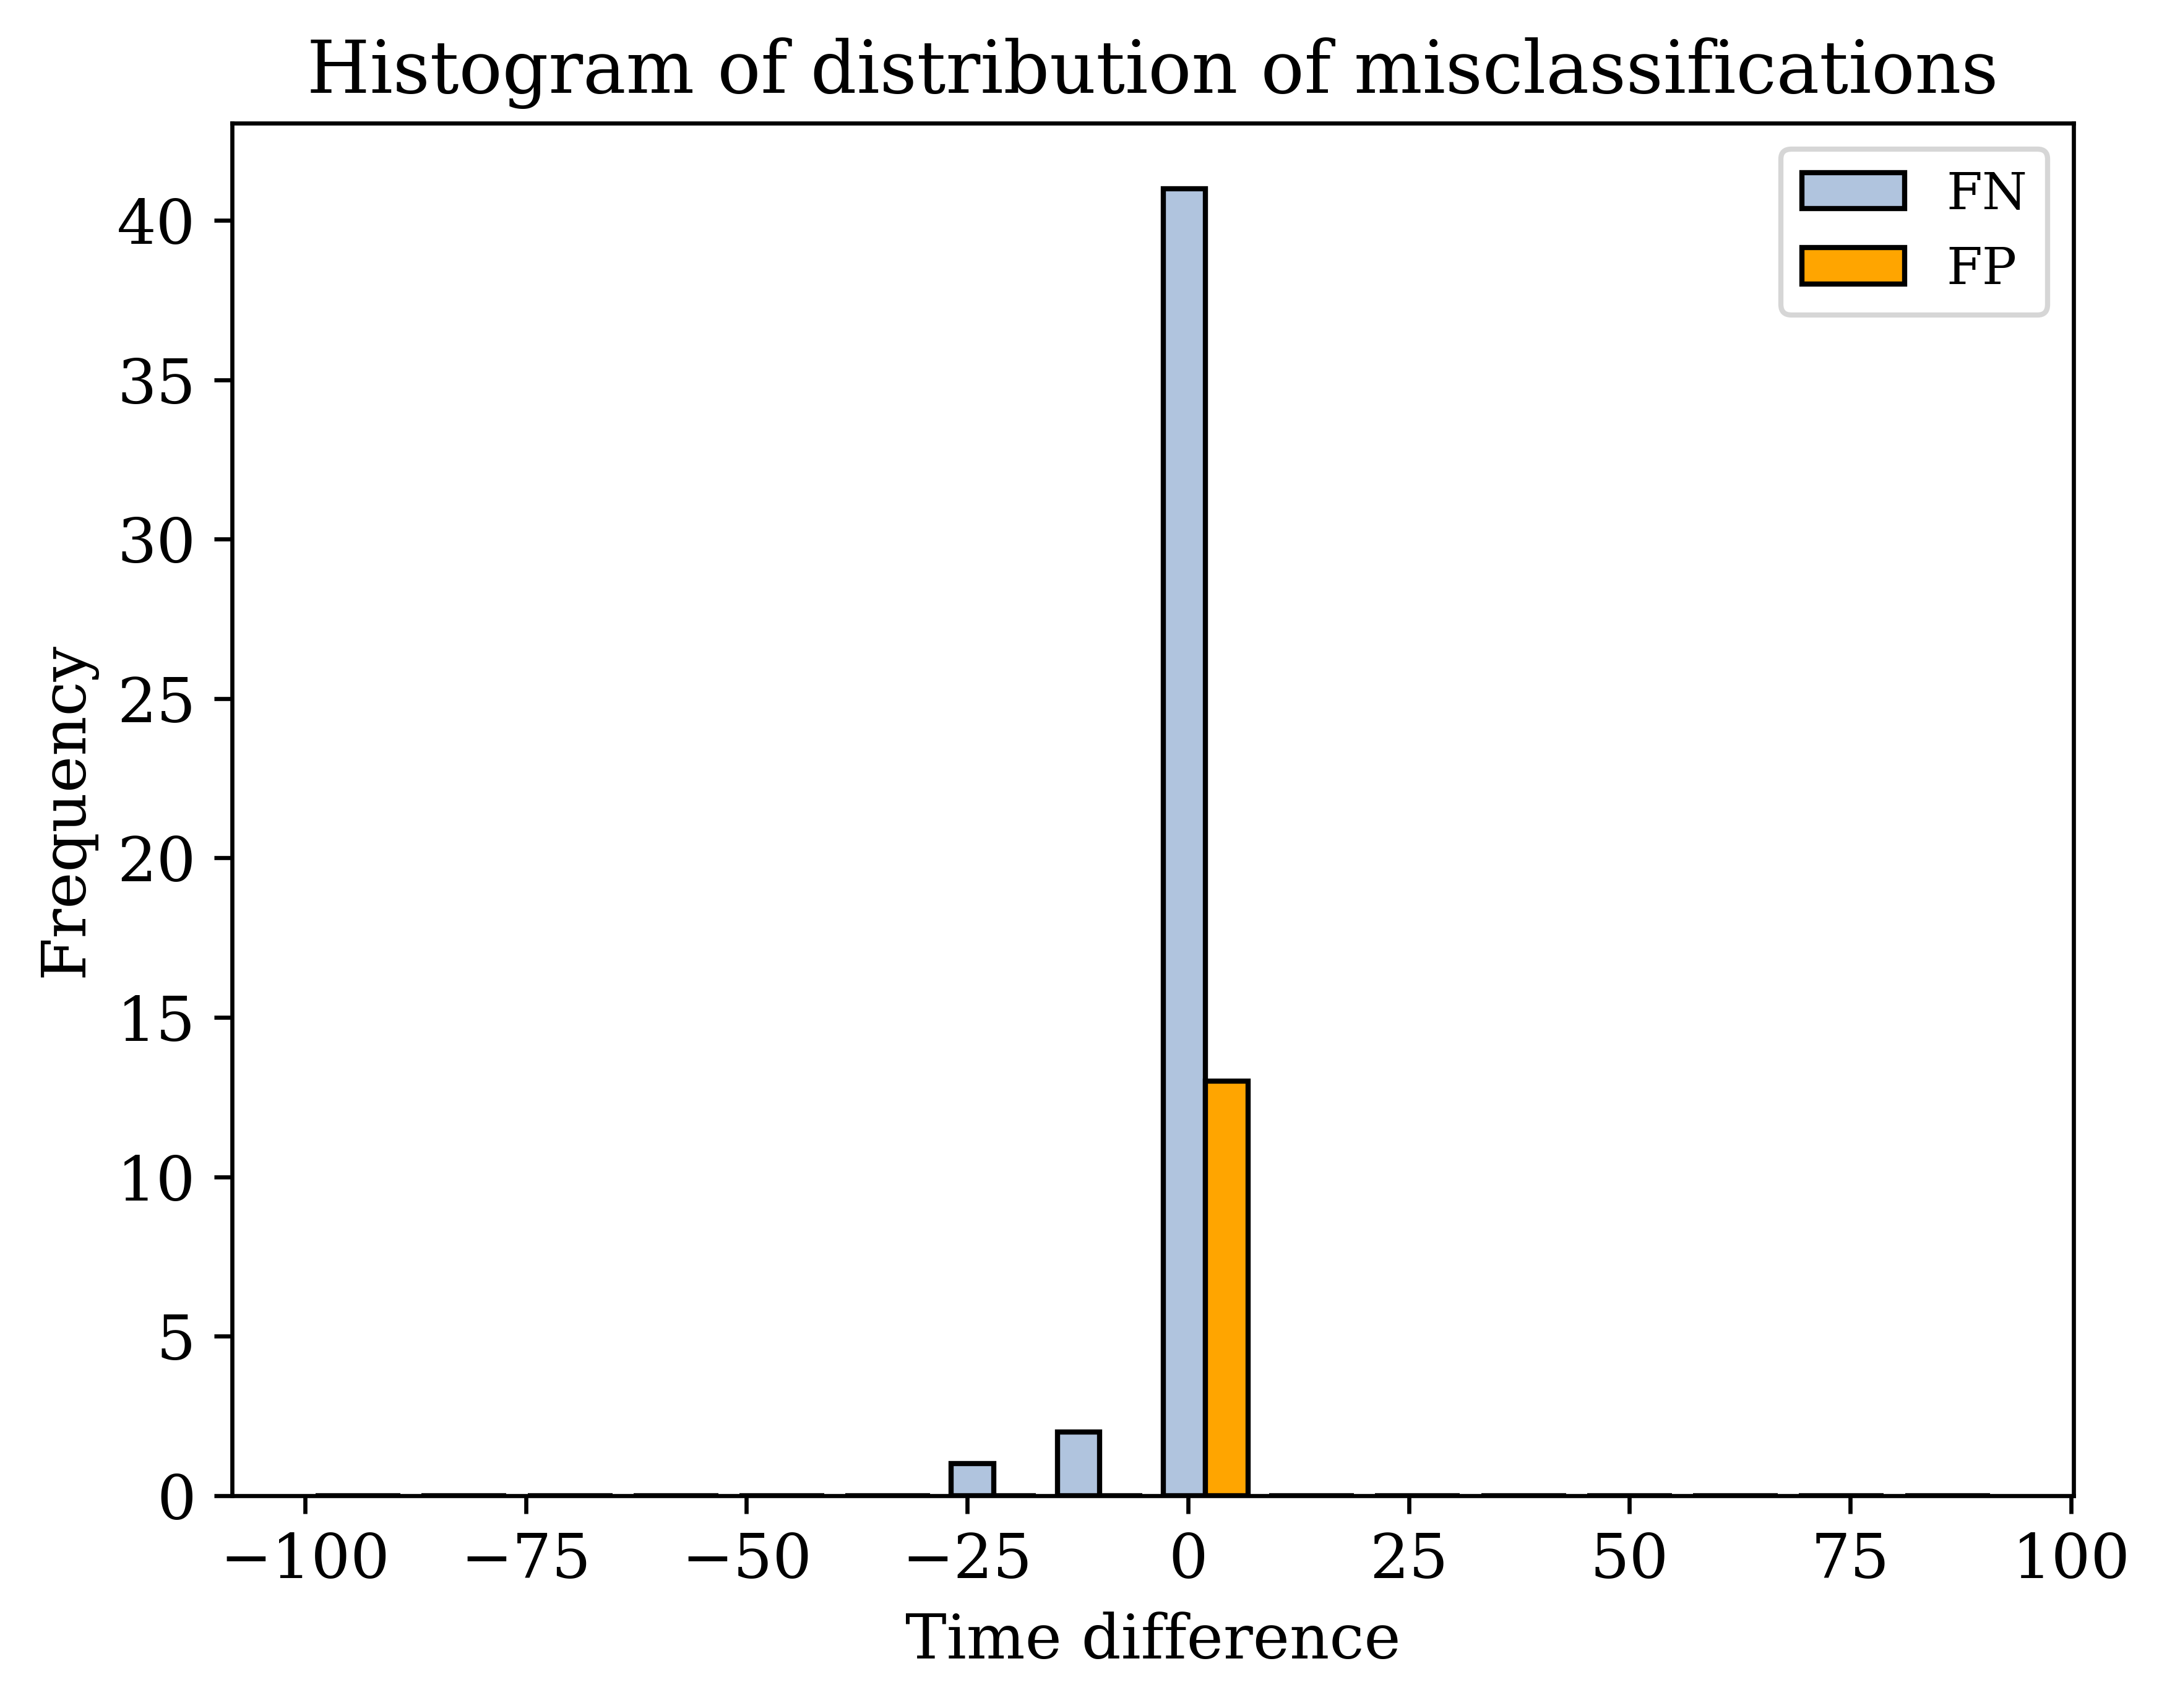

In [40]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/DDB_extra_all_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [41]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_2074/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_2074/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_2074/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

cut  0.01  0.1  1  10  100  TO
FP      0    5  6   2    0   0
FN      2   26  8   7    1   0

#### Statistical tests

In [42]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [43]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                query orig/rewr(med)  \
1466           0           0    JOB             5c-full2           orig   
2841           0           0  STATS  090-079-augF1-augA1           orig   
2519           0           0  STATS  063-109-augF1-augA1           orig   
2744           0           0  STATS              082-096           orig   
2025           1           1  STATS  022-125-augF1-augA1           rewr   

      orig(med)  rewr(med)  #relations  #conditions  #filters  ...  \
1466   2.414728   3.830490           5           10         5  ...   
2841   0.362975   0.434757           6           12         7  ...   
2519   0.250433   0.997339           5            9         5  ...   
2744   0.543298   0.577235           4            7         4  ...   
2025   0.240538   0.200869           4           10         7  ...   

      median(container counts)  q75(container counts)  min(branching factors)  \
1466                       1.0                    1.0                       1   
2841                       1.0                    1.0                       5   
2519                       1.0                    1.0                       1   
2744                       1.0                    1.0                       3   
2025                       1.0                    1.0                       1   

      max(branching factors)  mean(branching factors)  \
1466                       3                      2.0   
2841                       5                      5.0   
2519                       3                      2.0   
2744                       3                      3.0   
2025                       2                      1.5   

      median(branching factors)  q25(branching factors)  \
1466                        2.0                    1.50   
2841                        5.0                    5.00   
2519                        2.0                    1.50   
2744                        3.0                    3.00   
2025                        1.5                    1.25   

      q75(branching factors)  diff rewr-orig  pred(med)  
1466                    2.50        1.415762   2.414728  
2841                    5.00        0.071782   0.362975  
2519                    2.50        0.746906   0.250433  
2744                    3.00        0.033937   0.543298  
2025                    1.75       -0.039670   0.200869  

[5 rows x 32 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [44]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 450.0
P-value: 8.475840515980097e-18


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [45]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 5.633678056170741
P-value: 3.1645910903780147e-08


#### Important features using Gini importance

In [46]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters    #joins  \
Importance    0.002003     0.020097   0.02867  0.012099   

            min(est. cardinality)  max(est. cardinality)  \
Importance               0.160601               0.087761   

            mean(est. cardinality)  q25(est. cardinality)  \
Importance                0.075988               0.029674   

            median(est. cardinality)  q75(est. cardinality)  ...  \
Importance                  0.047959               0.100414  ...   

            mean(container counts)  q25(container counts)  \
Importance                0.155092                    0.0   

            median(container counts)  q75(container counts)  \
Importance                       0.0                    0.0   

            min(branching factors)  max(branching factors)  \
Importance                0.132803                 0.00058   

            mean(branching factors)  median(branching factors)  \
Importance                 0.052872                   0.005645   

            q25(branching factors)  q75(branching factors)  
Importance                0.015777                0.012987  

[1 rows x 23 columns]

In [47]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
min(est. cardinality)        0.160601
mean(container counts)       0.155092
min(branching factors)       0.132803
q75(est. cardinality)        0.100414
max(est. cardinality)        0.087761
mean(est. cardinality)       0.075988
mean(branching factors)      0.052872
median(est. cardinality)     0.047959
max(container counts)        0.041752
q25(est. cardinality)        0.029674
#filters                     0.028670
#conditions                  0.020097
depth                        0.017227
q25(branching factors)       0.015777
q75(branching factors)       0.012987
#joins                       0.012099
median(branching factors)    0.005645
#relations                   0.002003
max(branching factors)       0.000580
q75(container counts)        0.000000
median(container counts)     0.000000
q25(container counts)        0.000000
min(container counts)        0.000000

#### Visualization of the decision tree

In [48]:
clf.tree_.max_depth

17

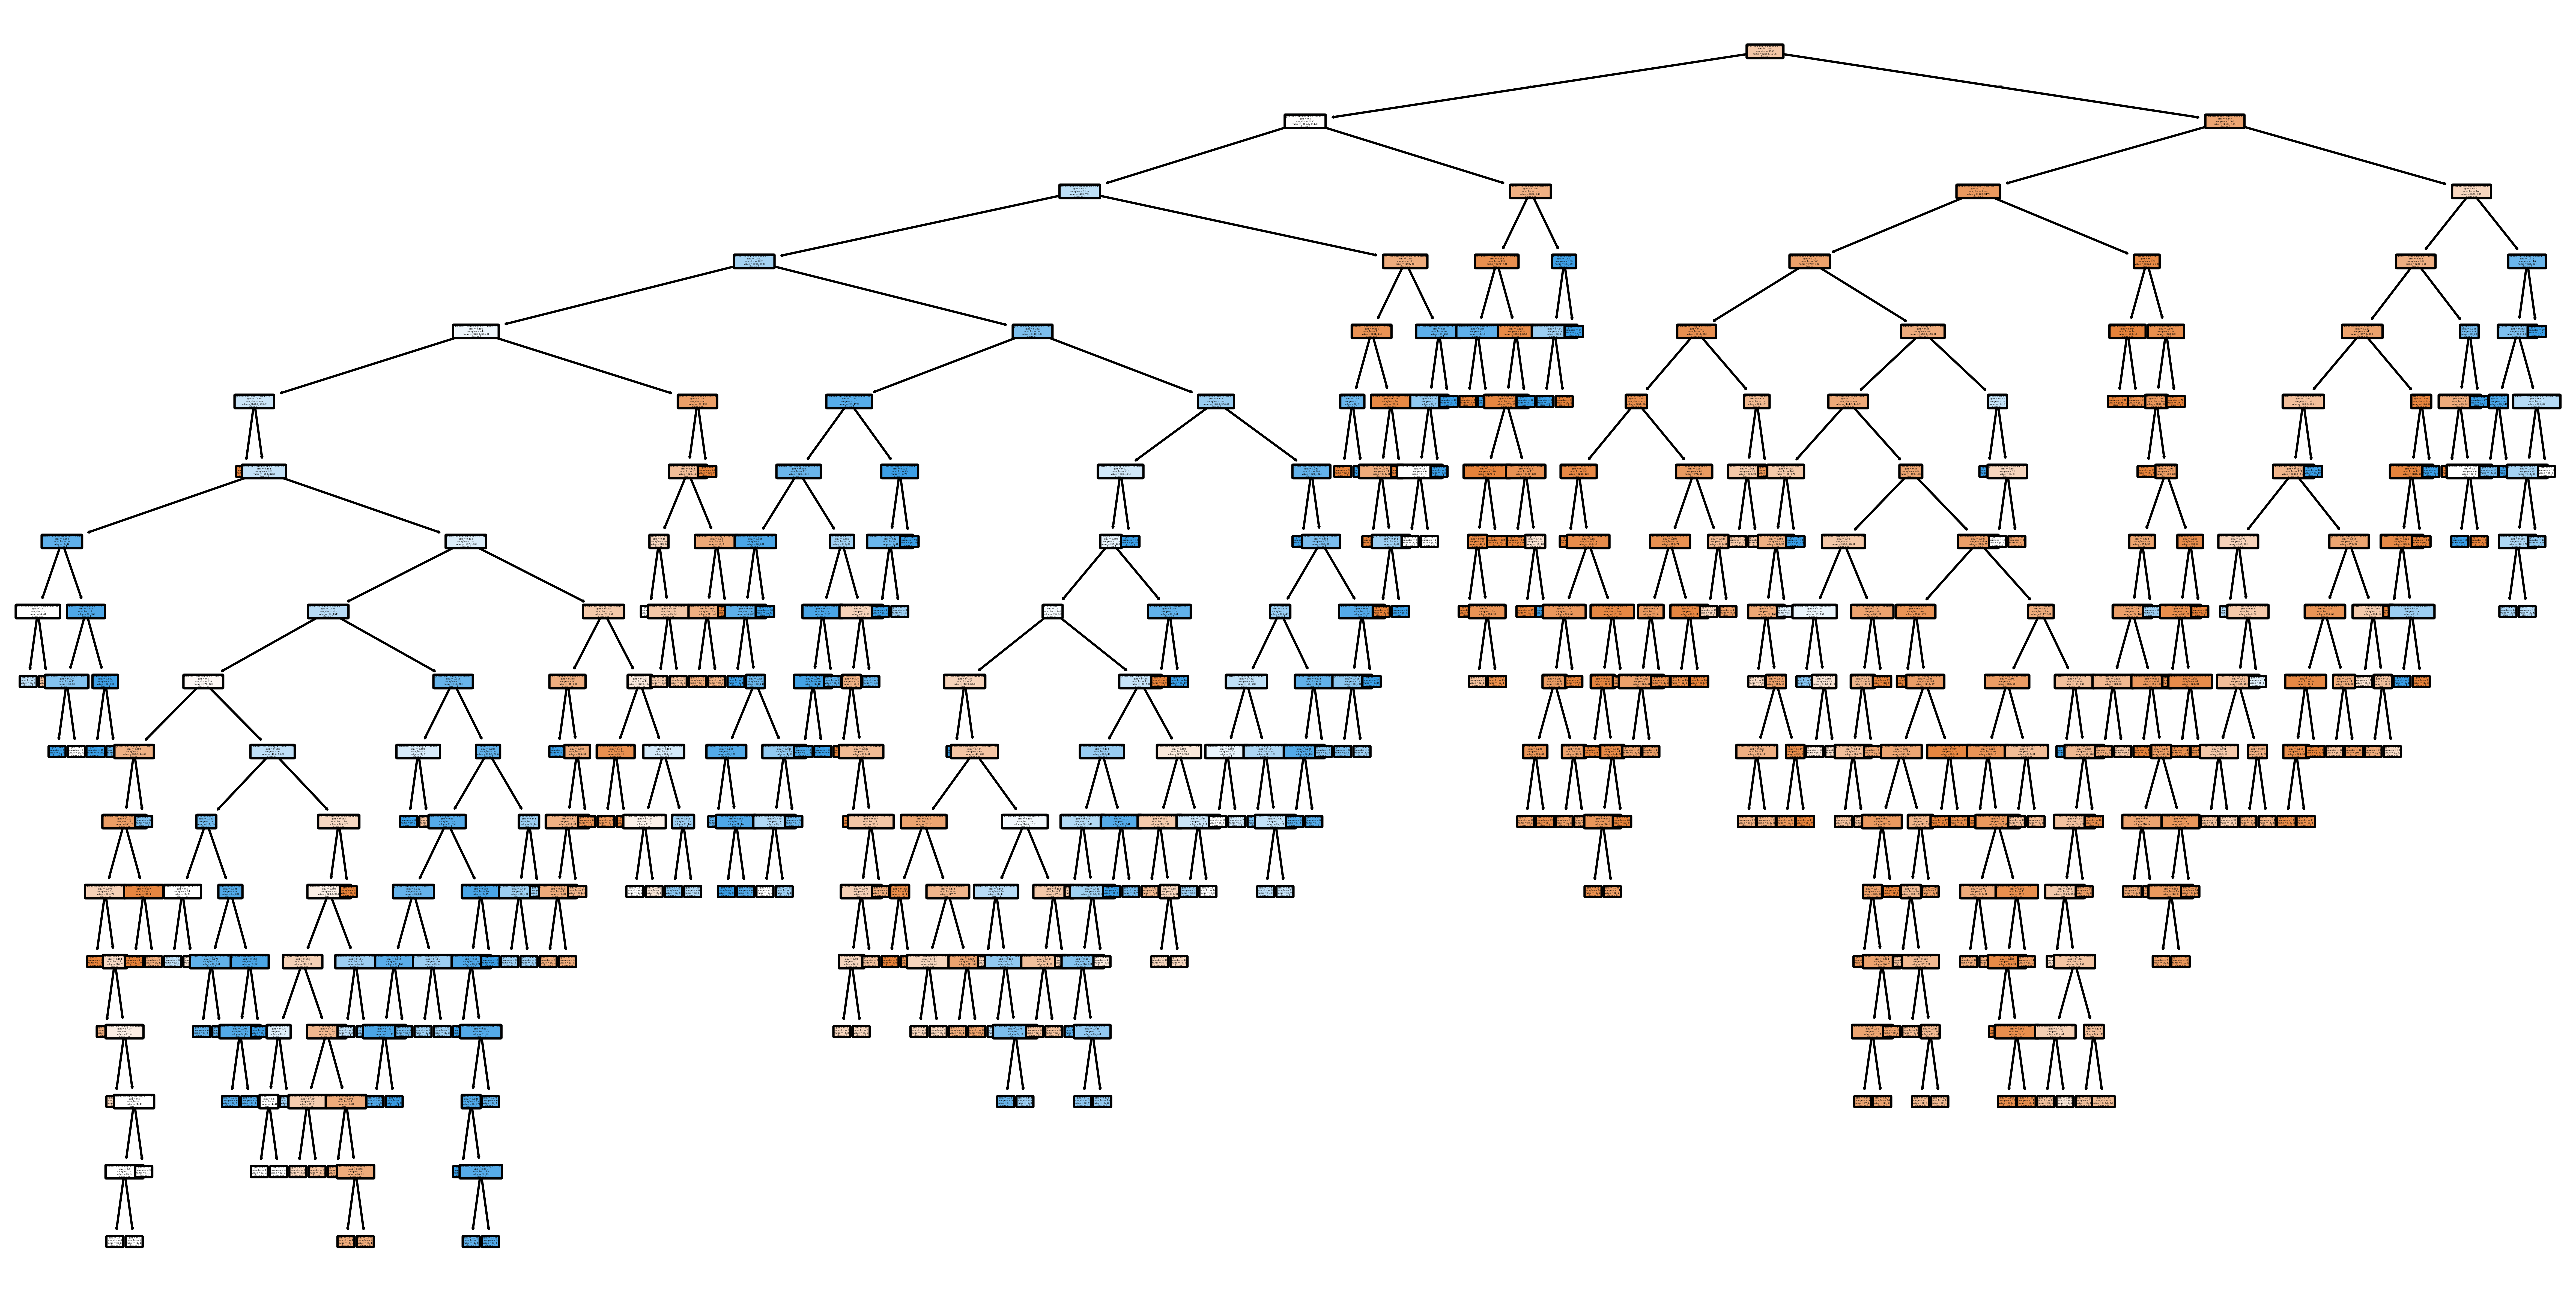

In [49]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/DDB_extra_all_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_2074/1440231542.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2074/1440231542.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2074/1440231542.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

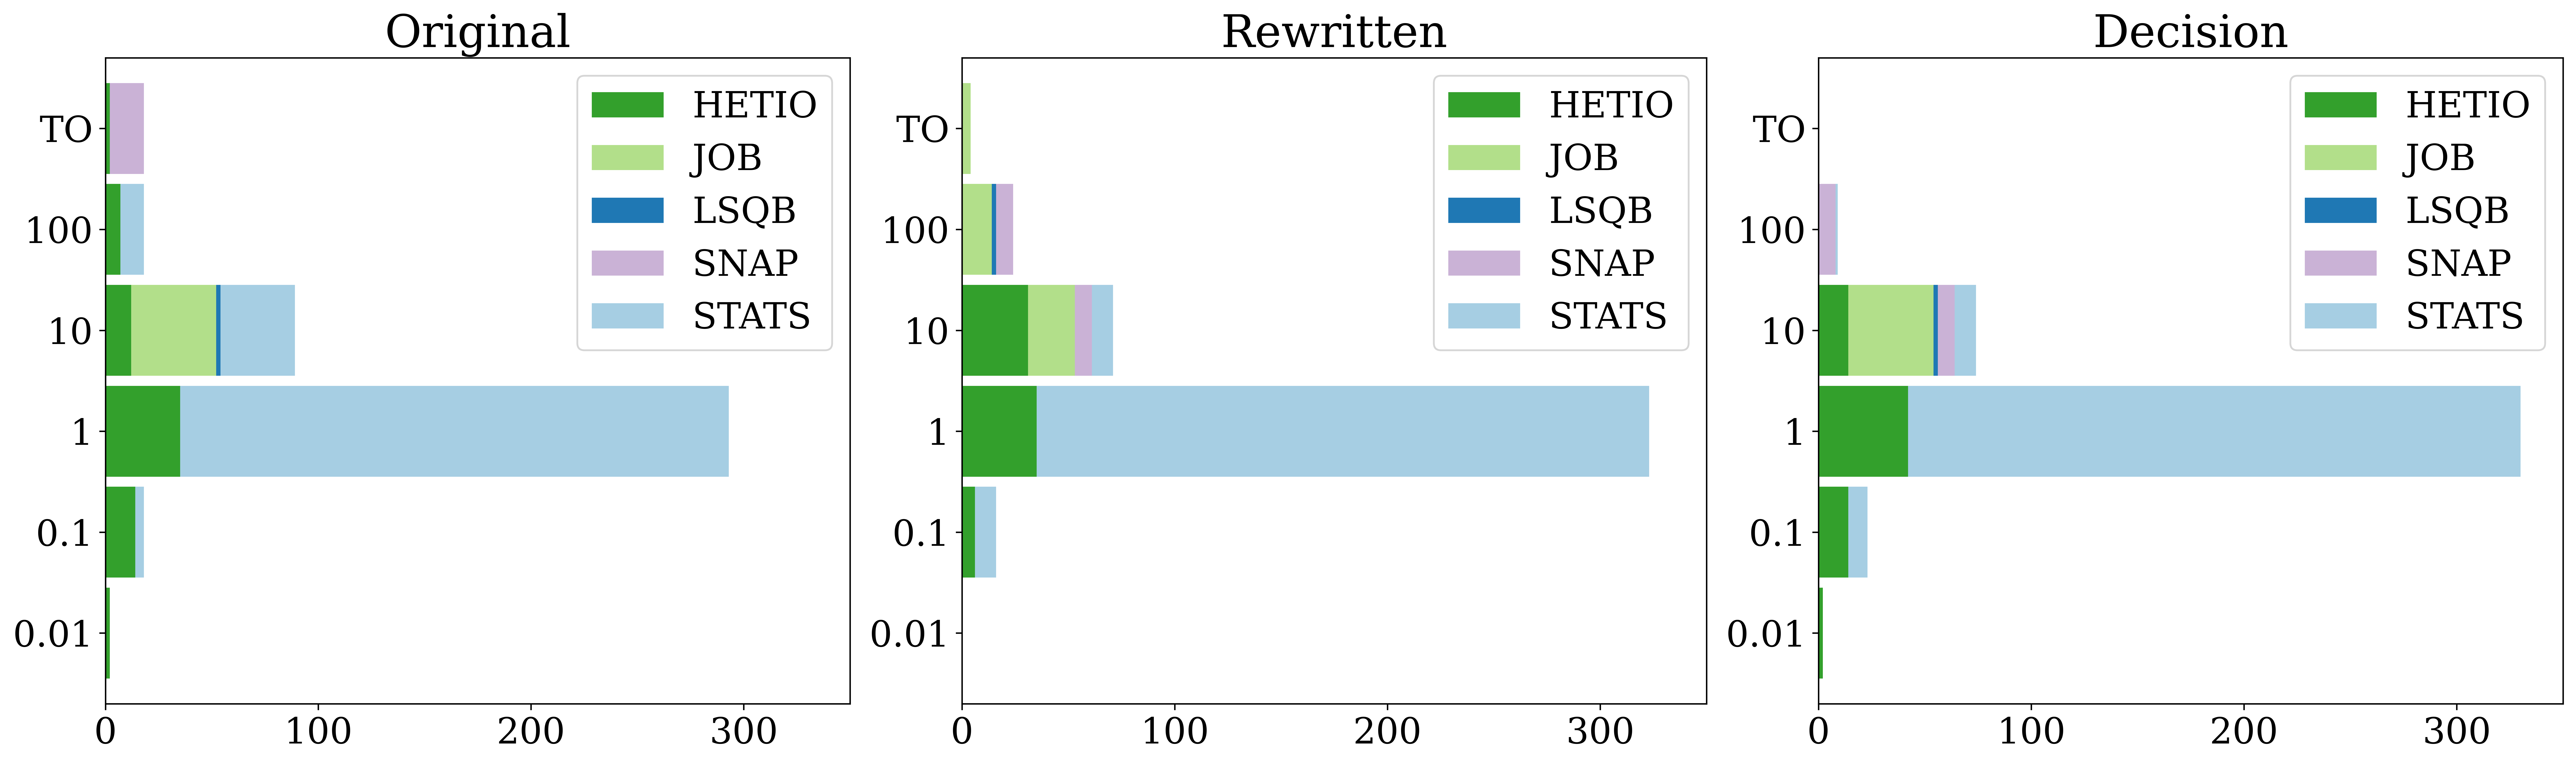

In [50]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/DDB_extra_all_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_2074/3914322093.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2074/3914322093.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_2074/3914322093.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

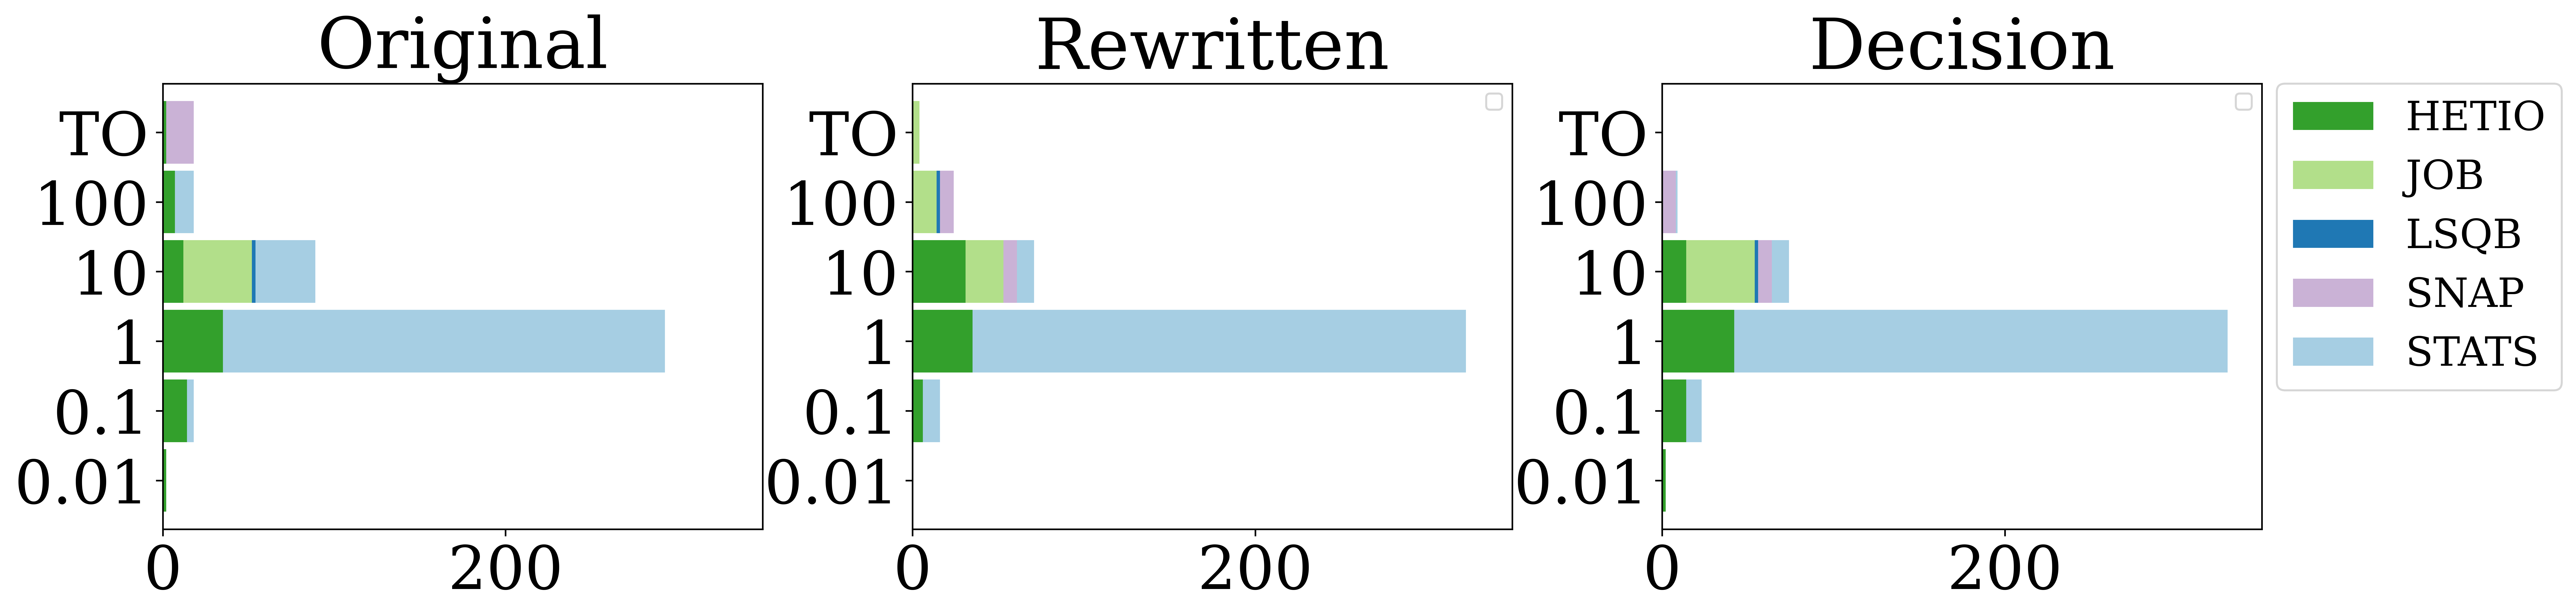

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/DDB_extra_all_runtimes_color.png') 
plt.show()


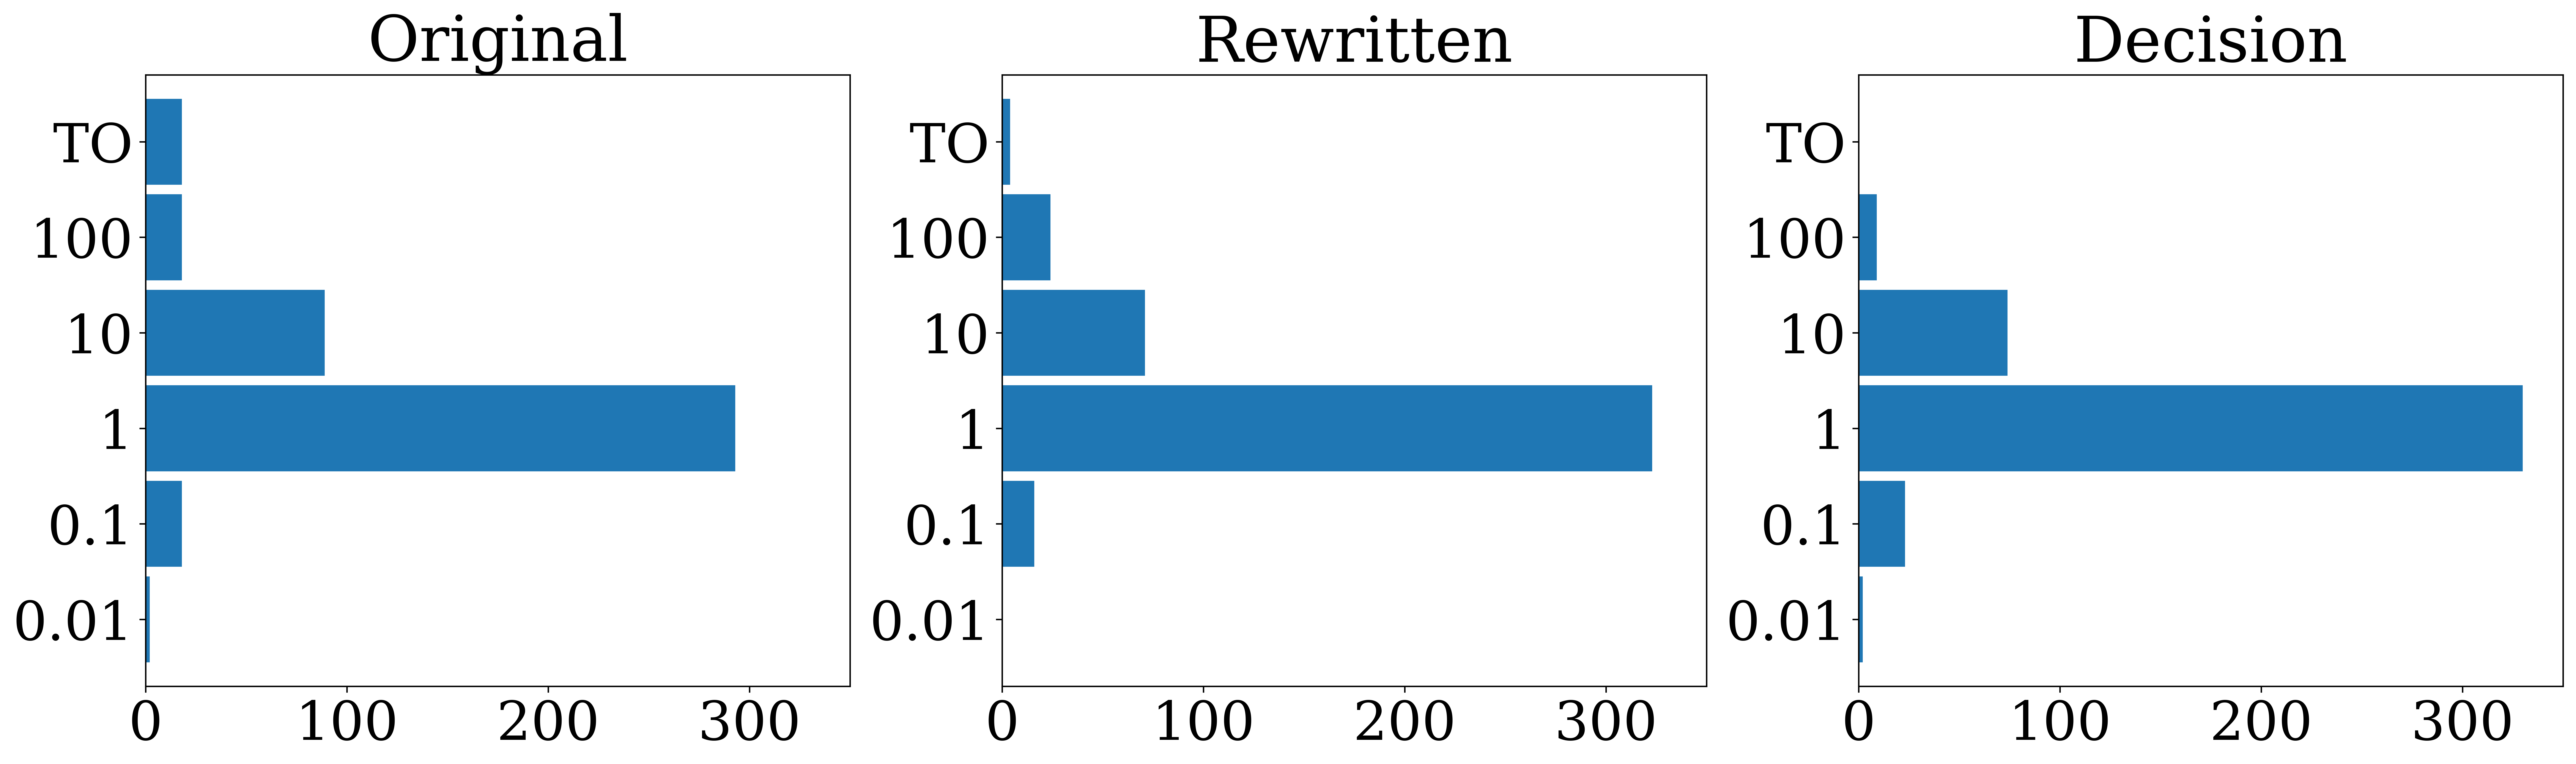

In [52]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/DDB_extra_all_runtimes.png')
plt.show()